In [2]:
from transformers import BertConfig, EncoderDecoderConfig, EncoderDecoderModel

config_encoder = BertConfig()
config_decoder = BertConfig()

config = EncoderDecoderConfig.from_encoder_decoder_configs(config_encoder, config_decoder)
model = EncoderDecoderModel(config=config)

RuntimeError: Failed to import transformers.models.encoder_decoder.modeling_encoder_decoder because of the following error (look up to see its traceback):
[WinError 127] The specified procedure could not be found. Error loading "c:\Users\saif8\miniconda3\lib\site-packages\torch\lib\cublas64_11.dll" or one of its dependencies.

In [8]:
from transformers import TFEncoderDecoderModel, BertTokenizer

model_name = "snrspeaks/t5-one-line-summary"

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = TFEncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

abstract = """We describe a system called Overton, whose main design goal is to support engineers in building, monitoring, and improving production 
machine learning systems. Key challenges engineers face are monitoring fine-grained quality, diagnosing errors in sophisticated applications, and 
handling contradictory or incomplete supervision data. Overton automates the life cycle of model construction, deployment, and monitoring by providing a 
set of novel high-level, declarative abstractions. Overton's vision is to shift developers to these higher-level tasks instead of lower-level machine learning tasks. 
In fact, using Overton, engineers can build deep-learning-based applications without writing any code in frameworks like TensorFlow. For over a year, 
Overton has been used in production to support multiple applications in both near-real-time applications and back-of-house processing. In that time, 
Overton-based applications have answered billions of queries in multiple languages and processed trillions of records reducing errors 1.7-2.9 times versus production systems.
"""

from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
input_ids = tokenizer.encode("summarize: " + abstract, return_tensors="tf", add_special_tokens=True)
generated_ids = model.generate(input_ids=input_ids,num_beams=5,max_length=50,repetition_penalty=2.5,length_penalty=1,early_stopping=True,num_return_sequences=3)
preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
print(preds)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['lm_head.weight', 'encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


['Overton: Building, Monitoring, and Improving Production Machine Learning Systems', 'Overton: Building, Deploying, and Monitoring Deep Machine Learning Systems', 'Overton: Building, Deploying, and Monitoring Machine Learning Systems']


In [11]:
from transformers import AutoTokenizer, EncoderDecoderModel

# let's perform inference on a long piece of text
ARTICLE_TO_SUMMARIZE = (
    """PG&E stated it scheduled the blackouts in response to forecasts for high winds
    amid dry conditions. The aim is to reduce the risk of wildfires. Nearly 800 thousand customers were 
    scheduled to be affected by the shutoffs which were expected to last through at least midday tomorrow."""
)
input_ids = tokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="tf").input_ids

# autoregressively generate summary (uses greedy decoding by default)
generated_ids = model.generate(input_ids)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
print(generated_text)

['Blackouts at PG&E']


In [302]:
from keras.utils import get_file
import os

get_file(
    origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
    extract=True,
)
dir = os.path.expanduser("~/.keras/datasets/simplebooks/")

In [303]:
f = open(dir + "simplebooks-92-raw/train.txt")
lines = f.readlines()
f.close()

In [304]:
sentences = []
for t in lines:
    if t == '\n':
        continue
    sentences.append(t)

sentences = ['[SEP]'.join(zipped_sentences) for zipped_sentences in zip(sentences[0::2], sentences[1::2])]

del lines

In [309]:
# import pickle
# with open("preprocessed_simplebooks.pkl", "wb") as f:
#     pickle.dump([input_ids_list, attention_mask_list, token_type_ids_list, input_ids_label_list], f)

In [2]:
import os
import random
import string

import tensorflow as tf

from transformers import BertTokenizer
import keras_nlp
import numpy as np
import pickle

with (open("./preprocessed_simplebooks.pkl", "rb")) as f:
    input_ids_list, attention_mask_list, token_type_ids_list, input_ids_label_list = pickle.load(f)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
max_seq_length = len(input_ids_list[0])
input_ids_list = np.array(input_ids_list).reshape(len(input_ids_list), -1)
attention_mask_list = np.array(attention_mask_list).reshape(len(attention_mask_list), -1)
token_type_ids_list = np.array(token_type_ids_list).reshape(len(token_type_ids_list), -1)
input_ids_label_list = np.array(input_ids_label_list).reshape(len(token_type_ids_list), -1)

In [4]:
max_seq_length

32

In [12]:
import keras_nlp
from keras import layers, optimizers, losses, Model
import tensorflow as tf
from transformers import BertConfig, TFBertModel

max_len = max_seq_length
encoder = TFBertModel.from_pretrained('bert-base-uncased')

vocab_size = tokenizer.vocab_size

input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
embedding = encoder(input_ids)[0]

transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(embedding)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(embedding, transformer_decoder)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(embedding, transformer_decoder)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(embedding, transformer_decoder)
transformer_decoder = keras_nlp.layers.TransformerDecoder(
    num_heads=12, 
    intermediate_dim=max_seq_length,
    dropout=0.1
)(embedding, transformer_decoder)

outputs = layers.Dense(vocab_size)(transformer_decoder)

model = Model(
    inputs=input_ids,
    outputs=outputs
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = optimizers.Adam(lr=5e-5)
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity])


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
c:\Users\saif8\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
 

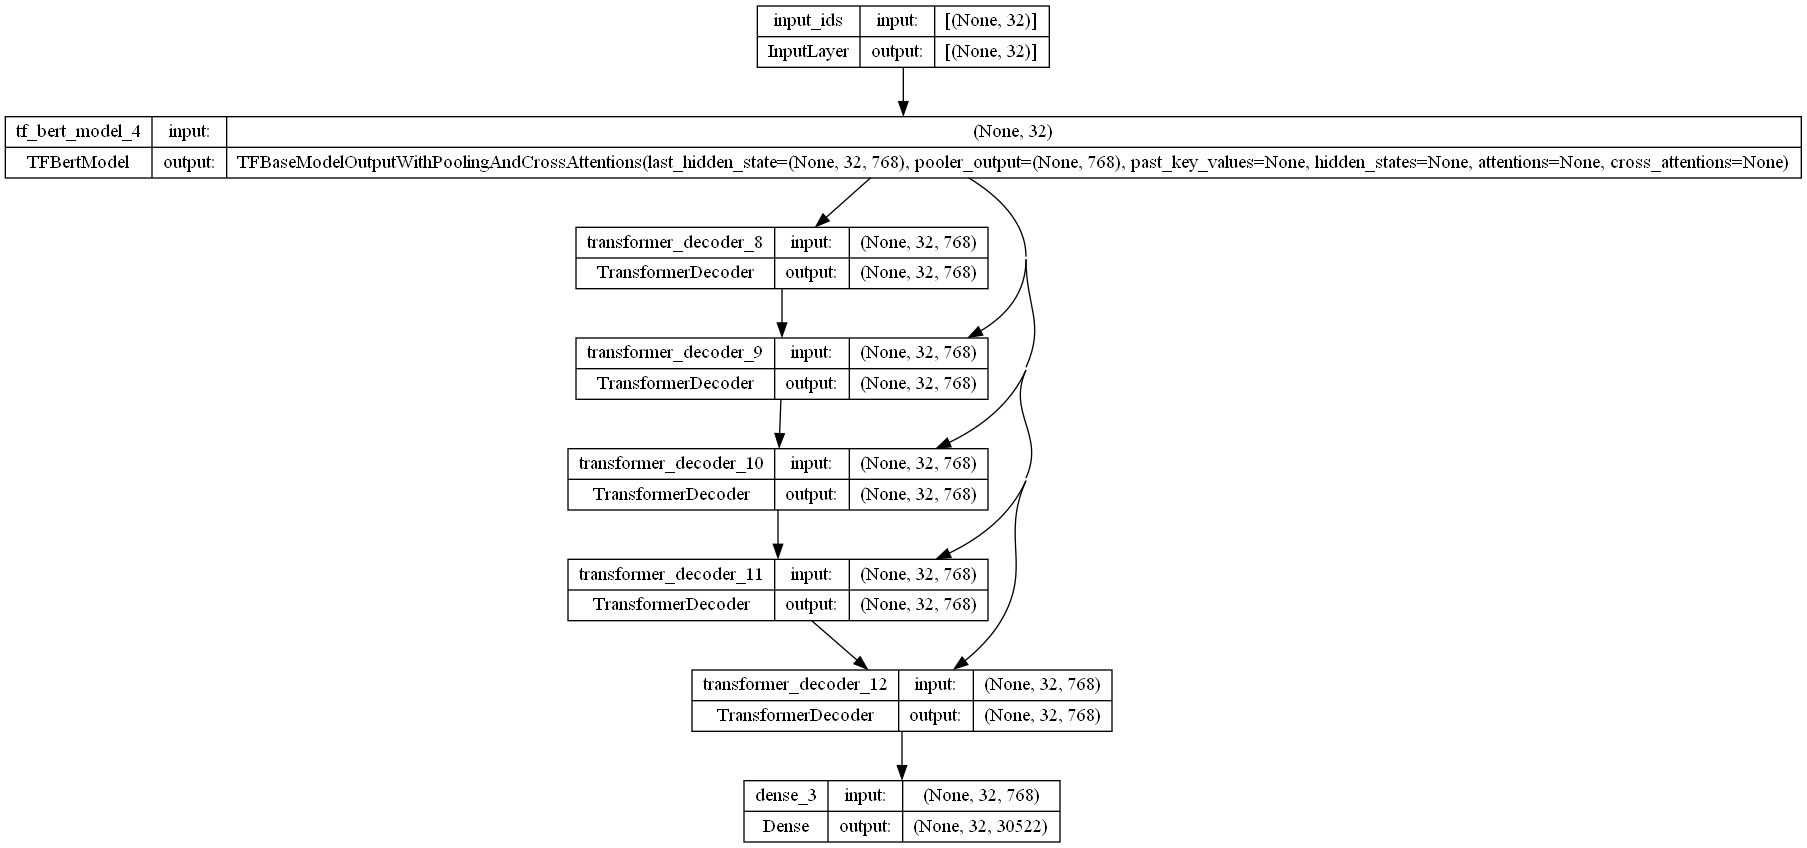

In [13]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
model.fit(input_ids_list[:400000], input_ids_label_list[:400000], verbose=1, epochs=25, batch_size=16)

Epoch 1/25
 6638/25000 [======>.......................] - ETA: 53:42 - loss: 1.1950 - perplexity: 3.5271

KeyboardInterrupt: 

In [16]:
# Define a function to preprocess text
def preprocess_text(text, max_seq_length):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Truncate the tokens to the specified max sequence length
    if len(tokens) > max_seq_length - 2:
        tokens = tokens[:(max_seq_length - 2)]#

    # Add special tokens for BERT
    tokens = ['[CLS]'] + tokens

    # Convert the tokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Create attention masks
    attention_mask = [1] * len(input_ids)
    padding_length = max_seq_length - len(input_ids)
    input_ids = input_ids + ([0] * padding_length)
    attention_mask = attention_mask + ([0] * padding_length)

    # Create token type IDs
    token_type_ids = [0] * len(input_ids)

    # Convert the input IDs, attention masks, and token type IDs to arrays
    input_ids = np.asarray(input_ids, dtype=np.int32)
    attention_mask = np.asarray(attention_mask, dtype=np.int32)
    token_type_ids = np.asarray(token_type_ids, dtype=np.int32)

    # Return the preprocessed data
    return input_ids, attention_mask, token_type_ids

sample = 'the man'
a, b, c = preprocess_text(sample, max_seq_length)

predicted = model(a.reshape(-1, len(a)))
# preprocessed_sample

In [17]:
token_list = []
sample_length = len(sample.split(' '))
for i in range(sample_length, max_seq_length-2):
    tokenized_sample, _, _ = preprocess_text(sample, max_seq_length)
    predicted = model(tokenized_sample.reshape(-1, len(a)))

    logits, indices = tf.math.top_k(predicted[0], k=10, sorted=True)
    indices = np.asarray(indices).astype('int32')
    preds = tf.nn.softmax(tf.expand_dims(logits, 0))[0]
    preds = np.asarray(preds).astype("float32")

    new_token = tokenizer.decode([np.random.choice(indices[i+2], p=preds[i+2])])
    sample = sample + ' ' + new_token

In [18]:
sample

"the man i [SEP] ##s s s s m m m m m m m m m m m m m m m m m m m m m '"

In [338]:
prompt_tokens =  tf.convert_to_tensor(tokenizer.convert_tokens_to_ids(['[CLS]', 'nice']))
NUM_TOKENS_TO_GENERATE = max_seq_length
global tokenized_text

def token_logits_fn(inputs):
    print(inputs)
    global tokenized_text
    tokenized_text = inputs
    padding_length = max_seq_length - len(inputs[0])
    input_ids = inputs[0] + ([0] * padding_length)
    cur_len = 256
    output = model(input_ids)
    print('out', output[:, cur_len - 1, :])
    return output[:, cur_len - 1, :]  # return next token logits

output_tokens = keras_nlp.utils.greedy_search(
    token_logits_fn,
    prompt_tokens,
    max_length=NUM_TOKENS_TO_GENERATE,
)

txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

tf.Tensor(
[[ 101 3835    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(1, 32), dtype=int32)


InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Incompatible shapes: [32] vs. [0] [Op:AddV2]

In [381]:
# tokenized = [np.argmax(predicted[i].numpy()) for i in range(max_len)]
logits, indices = tf.math.top_k(predicted[0], k=32, sorted=True)
indices = np.asarray(indices).astype('int32')
preds = tf.nn.softmax(tf.expand_dims(logits, 0))[0]
preds = np.asarray(preds).astype("float32")
np.random.choice(indices[4], p=preds[4])

12713

In [340]:
np.argmax(tf.nn.softmax(tf.expand_dims(logits, 0))[0].numpy())

352

In [382]:
tokenizer.decode([token[0] for token in indices])

'[CLS] boys, she exclaimed. [SEP] iv [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [322]:
indices[4]

array([2008, 2216, 1997, 2023, 1012, 1010, 2000, 1005, 2053, 2025, 2001,
       1996,  102, 1025, 2028, 1024, 2045, 2061, 1011, 2055, 2107, 1037,
       1998, 2056, 2009, 1999, 2204, 2002, 2059, 2018, 2069, 2006])